<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP3_BitPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Milestone Project: BitPredict

**Forecasting: Principles and Practice** (3rd ed): https://otexts.com/fpp3/

by Rob J Hyndman and George Athanasopoulos

Monash University, Australia

# Importações

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

## Constantes

In [3]:
SEMENTE = 2008193

COR_TREINO   = '#663399'
COR_PREVISAO = '#f22424'
COR_TESTE    = '#345cd3'

LINHA_ESPESSURA = 1

TAMANHO_CNN = 128

ATIVACAO_CNN = 'relu'
ATIVACAO_HORIZONTE = 'linear'

PERDA = 'mae'
METRICAS = ['mae', 'mse']

TAMANHO_LOTE = 128
CAMINHO_MARCOS = 'marcos'

## Funções

In [4]:
def grafico_series(X_treino=[], y_treino=[],
                   X_teste=[], y_teste=[],
                   X_previsao=[], y_previsao=[],
                   inicio=0, fim=None):

    if len(X_treino) > 0:
        sns.lineplot(x=X_treino[inicio:fim], y=y_treino[inicio:fim], color=COR_TREINO, linewidth=LINHA_ESPESSURA, label='Treino')

    if len(X_teste) > 0:
        sns.lineplot(x=X_teste[inicio:fim], y=y_teste[inicio:fim], color=COR_TESTE, linewidth=LINHA_ESPESSURA, label='Teste')

    if len(X_previsao) > 0:
        sns.lineplot(x=X_previsao[inicio:fim], y=y_previsao[inicio:fim], color=COR_PREVISAO, linewidth=LINHA_ESPESSURA, label='Previsão')

    plt.title('Fechamentos')
    plt.xlabel('')
    plt.ylabel('Valor em dólares')

    plt.xticks(rotation=-45)

    plt.legend(loc=(1.03, 0.88), frameon=True, facecolor='white')

    plt.show()

def grafico_metrica(metrica, titulo=None):

    metrica = pd.DataFrame(metrica).T

    sns.barplot(data=metrica, color=COR_TREINO)

    plt.title(titulo)
    plt.xlabel('Modelo')
    plt.ylabel('')

    plt.show()

def mean_absolute_scaled_error(y_teste, y_previsao):

    # Mean absolute error
    mae = tf.reduce_mean(tf.abs(tf.subtract(y_teste, y_previsao)))

    # Mean absolute error de previsão ingênua (Sem período.)
    mae_ingenuo = tf.reduce_mean(tf.abs(tf.subtract(y_teste[1:], y_teste[:-1])))

    return tf.divide(mae, mae_ingenuo)

def metricas_modelo(y_teste, y_previsao):

    mae = mean_absolute_error(y_teste, y_previsao)
    rmse = tf.sqrt(mean_squared_error(y_teste, y_previsao))
    mape = mean_absolute_percentage_error(y_teste, y_previsao)
    mase = mean_absolute_scaled_error(y_teste, y_previsao)

    return {'Mean Absolute Error': mae.numpy(),
            'Root Mean Squared Error': rmse.numpy(),
            'Mean Absolute Percentage Error': mape.numpy(),
            'Mean Absolute Scaled Error': mase.numpy()}

def criar_janelas(dados, janela_tamanho, horizonte_tamanho):

    # Array 2D de 0 a janela_tamanho + horizonte_tamanho.
    janela_primaria = np.expand_dims(np.arange(janela_tamanho + horizonte_tamanho), axis=0)

    # Array 2D com todas as janelas completas com os índices dos dados.
    indices = janela_primaria + np.expand_dims(np.arange(len(dados) - (janela_tamanho + horizonte_tamanho - 1)), axis=0).T

    # Dados em formato de janelas com horizontes.
    janelas_horizontes = dados[indices]

    # Retorna os dados em formato janelas, horizonte.
    return janelas_horizontes[:, :-horizonte_tamanho], janelas_horizontes[:, -horizonte_tamanho:]

def separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2):

    quantidade_teste = int(len(janelas) * (1 - tamanho_teste))

    janelas_treino    = janelas[:quantidade_teste]
    janelas_teste     = janelas[quantidade_teste:]
    horizontes_treino = horizontes[:quantidade_teste]
    horizontes_teste  = horizontes[quantidade_teste:]

    return janelas_treino, janelas_teste, horizontes_treino, horizontes_teste

def criar_marco_modelo(modelo_nome, caminho='marcos'):

    return ModelCheckpoint(filepath=os.path.join(caminho, modelo_nome),
                           monitor='val_loss',
                           save_best_only=True,
                           verbose=0)

# Dados

In [5]:
colunas = ['Data', 'Abertura', 'Máximo', 'Mínimo', 'Fechamento']

df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/dados/BTC_USD_20140917_20230131.csv',
                 header=0,
                 names=colunas,
                 usecols=colunas,
                 parse_dates=['Data'],
                 index_col=['Data'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3059 entries, 2014-09-17 to 2023-01-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Abertura    3059 non-null   float64
 1   Máximo      3059 non-null   float64
 2   Mínimo      3059 non-null   float64
 3   Fechamento  3059 non-null   float64
dtypes: float64(4)
memory usage: 119.5 KB


In [7]:
df

,Abertura,Máximo,Mínimo,Fechamento
Data,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...
2023-01-27,23030.716797,23417.720703,22654.593750,23078.728516
2023-01-28,23079.964844,23165.896484,22908.845703,23031.089844
2023-01-29,23031.449219,23919.890625,22985.070313,23774.566406


In [8]:
df.describe()

,Abertura,Máximo,Mínimo,Fechamento
count,3059.000000,3059.000000,3059.000000,3059.000000
mean,12931.188036,13256.306288,12570.103885,12937.054107
std,16126.299406,16538.601114,15650.315751,16122.253398
min,176.897003,211.731003,171.509995,178.102997
25%,688.562011,704.736023,674.479981,689.175506
50%,7194.892090,7356.223633,7029.289063,7202.844238
75%,17092.044922,17464.872071,16789.533203,17097.668945
max,67549.734375,68789.625000,66382.062500,67566.828125


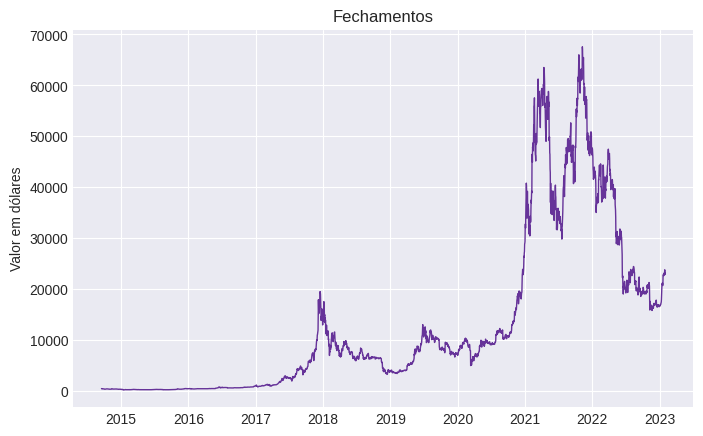

In [9]:
sns.lineplot(data=df, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares');

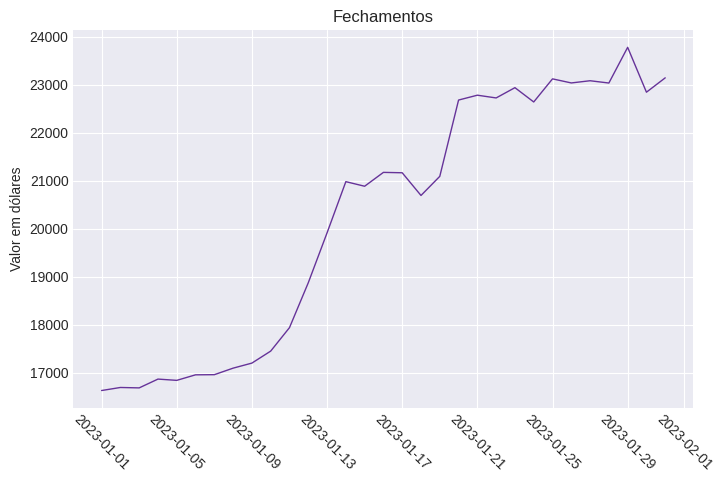

In [10]:
df_recente = df[df.index >= '2023-01-01']

sns.lineplot(data=df_recente, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares')

plt.xticks(rotation=-45);

In [11]:
treino_tamanho = int(len(df) * 0.8)  # 80% da base
treino_tamanho

2447

In [12]:
X_train = df[:treino_tamanho].index
y_train = df[:treino_tamanho]['Fechamento'].to_numpy()

X_test = df[treino_tamanho:].index
y_test = df[treino_tamanho:]['Fechamento'].to_numpy()

len(X_train), len(y_train), len(X_test), len(y_test)

(2447, 2447, 612, 612)

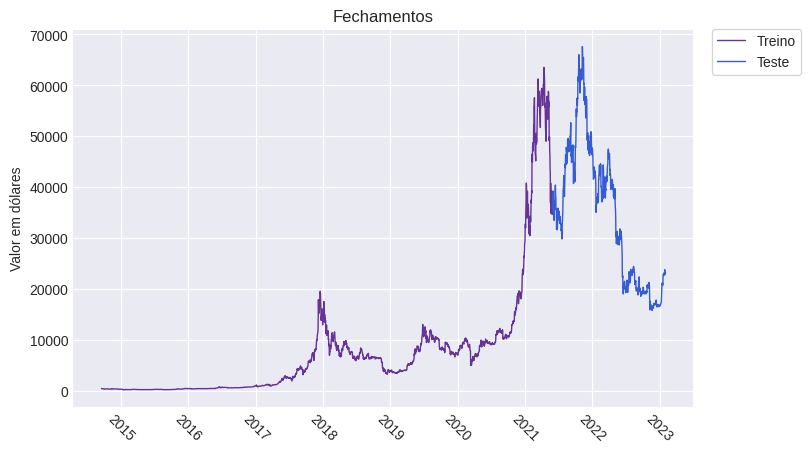

In [13]:
grafico_series(X_treino=X_train, y_treino=y_train,
               X_teste=X_test, y_teste=y_test)

# Modelos

0. Ingênuo
1. Denso (7 janelas, 1 horizonte.)
2. Denso (30 janelas, 1 horizonte.)
3. Denso (30 janelas, 7 horizontes.)
4. Conv1D
5. LSTM
6. Denso com dados multivariados
7. N-BEATS
8. Conjunto (Ensemble. Múltilplos modelos com funções de perda diferentes.)
9. Previsão futura
10. Denso com dados turcos (Turkey problem/data.)

---
Janelas: número de intervalos de tempo utilizados para fazer a previsão (passado).

Horizontes: número de intervalos de tempo da previsão (futuro).

In [14]:
metricas = [None] * 11

## Modelo 0: Ingênuo

Naïve method: https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method

Para previsões ingênuas, simplesmente definimos todas as previsões como o valor da observação anterior.

In [15]:
y_pred = y_test[:-1]

In [16]:
y_test[:10], y_test[-10:], y_pred[:10], y_pred[-10:]

(array([35678.128906, 37332.855469, 36684.925781, 37575.179688,
        39208.765625, 36894.40625 , 35551.957031, 35862.378906,
        33560.707031, 33472.632813]),
 array([22720.416016, 22934.431641, 22636.46875 , 23117.859375,
        23032.777344, 23078.728516, 23031.089844, 23774.566406,
        22840.138672, 23139.283203]),
 array([35678.128906, 37332.855469, 36684.925781, 37575.179688,
        39208.765625, 36894.40625 , 35551.957031, 35862.378906,
        33560.707031, 33472.632813]),
 array([22777.625   , 22720.416016, 22934.431641, 22636.46875 ,
        23117.859375, 23032.777344, 23078.728516, 23031.089844,
        23774.566406, 22840.138672]))

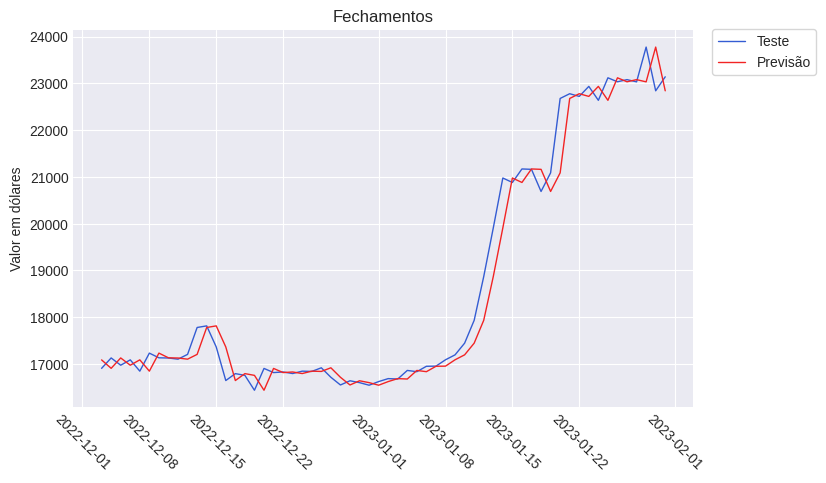

In [17]:
grafico_series(X_teste=X_test, y_teste=y_test,
               X_previsao=X_test[1:], y_previsao=y_pred,
               inicio=-60)

In [18]:
metricas[0] = metricas_modelo(y_test[1:], y_pred)

## Modelo 1: Denso (7 janelas, 1 horizonte.)

In [19]:
dados = df['Fechamento'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [20]:
tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_1_denso_7j_1h'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

historico = modelo.fit(x=janelas_treino,
                       y=horizontes_treino,
                       epochs=100,
                       batch_size=TAMANHO_LOTE,
                       validation_data=(janelas_teste, horizontes_teste),
                       callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
                       verbose=0)

In [21]:
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 4ms/step - loss: 995.4261 - mae: 995.4261 - mse: 2012570.1250


[995.4261474609375, 995.4261474609375, 2012570.125]

In [22]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 4ms/step - loss: 896.1097 - mae: 896.1097 - mse: 1744357.1250


[896.1096801757812, 896.1096801757812, 1744357.125]

In [23]:
previsoes = modelo.predict(janelas_teste)

20/20 [==============================] - 0s 4ms/step


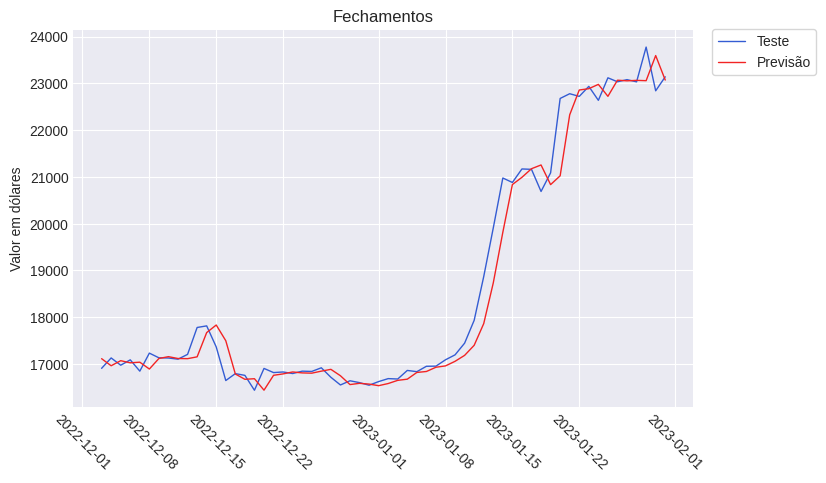

In [39]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [27]:
metricas[1] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

# Outros modelos

Other kinds of time series forecasting models which can be used for baselines and actual forecasts: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

# Comparação dos modelos

In [28]:
pd.DataFrame([m for m in metricas if m is not None]).T

,0,1
Mean Absolute Error,860.374223,896.109558
Root Mean Squared Error,1274.550527,1320.741089
Mean Absolute Percentage Error,2.424728,2.526809
Mean Absolute Scaled Error,1.001516,1.043113


In [29]:
# for titulo in metricas[0].keys():
#     grafico_metrica([m[titulo] for m in metricas if m is not None], titulo)